# Quantitative analysis of the runs with different mass balance calibrations
...

In [1]:
# import section
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

In [2]:
def read_dataset(path):
    # read dataset
    ds = xr.load_dataset(path)
    # sort by temperature bias
    ds = ds.sortby('temp_bias')
    # cast normalized dimension from int to bool
    ds['normalized'] = [bool(norm) for norm in ds.normalized]

    return ds

In [14]:
# read dataset
path = '/Users/oberrauch/work/master/data/cluster_output/ref_dfs/ref_df_runs.nc'
ds = read_dataset(path)
ds = ds.sortby('ref_df')
ds

<xarray.Dataset>
Dimensions:         (mb_model: 2, normalized: 2, ref_df: 3, rgi_id: 13, temp_bias: 3, time: 10001)
Coordinates:
    hydro_year      (time) int64 0 1 2 3 4 5 ... 9995 9996 9997 9998 9999 10000
    calendar_year   (time) int64 -1 0 1 2 3 4 ... 9994 9995 9996 9997 9998 9999
    calendar_month  (time) int64 10 10 10 10 10 10 10 ... 10 10 10 10 10 10 10
    hydro_month     (time) int64 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1 1
    model           <U3 'vas'
  * temp_bias       (temp_bias) float64 -0.5 0.0 0.5
  * rgi_id          (rgi_id) object 'RGI60-11.01450' 'RGI60-11.03643' ... 'sum'
  * normalized      (normalized) bool False True
  * time            (time) float64 0.0 1.0 2.0 3.0 ... 9.998e+03 9.999e+03 1e+04
  * mb_model        (mb_model) object 'random' 'constant'
  * ref_df          (ref_df) object 'psf1.75 tm-1.75' ... 'psf2.50 tm-1.25'
Data variables:
    volume          (ref_df, mb_model, normalized, temp_bias, time, rgi_id) float64 ...
    area            (ref_df, mb_model, normalized, temp_bias, time, rgi_id) float64 ...
    length          (ref_df, mb_model, normalized, temp_bias, time, rgi_id) float64 ...
    ela             (ref_df, mb_model, normalized, temp_bias, time, rgi_id) float64 ...
Attributes:
    description:    OGGM model output
    oggm_version:   1.3.2.dev113+g17c2289
    calendar:       365-day no leap
    creation_date:  2020-10-24 11:38:08

Look at **constant mass balance** first...

In [15]:
for rgi_id in ds.rgi_id:
    for ref_df in ds.ref_df:
        ds_sel = ds.sel(rgi_id=rgi_id, ref_df=ref_df, normalized=False, mb_model='constant')

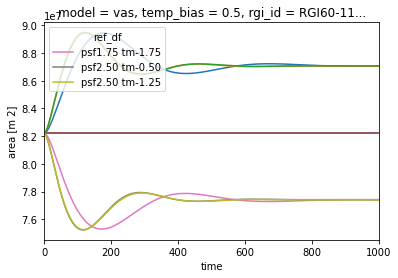

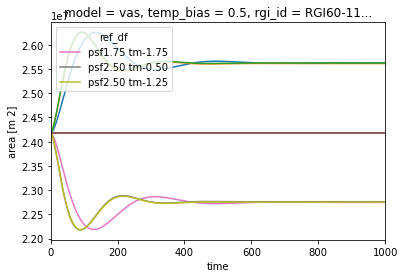

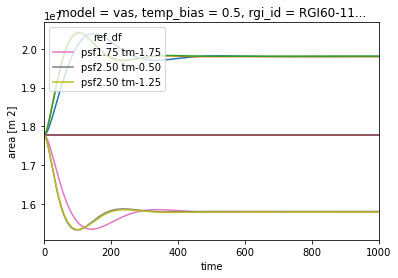

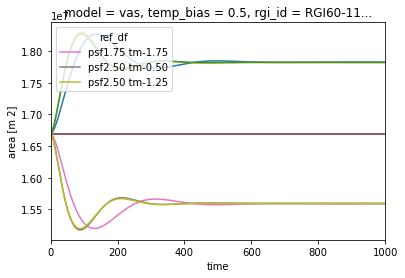

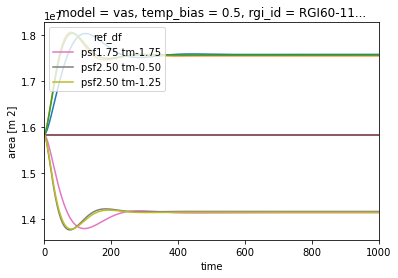

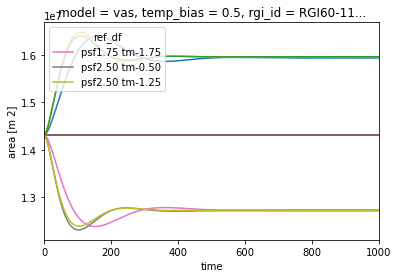

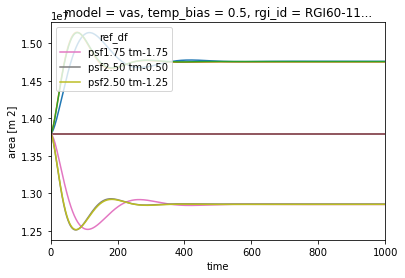

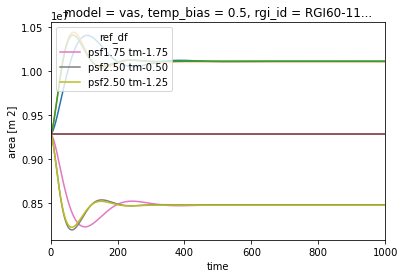

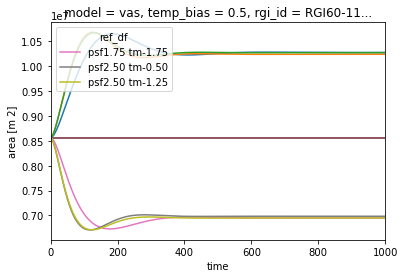

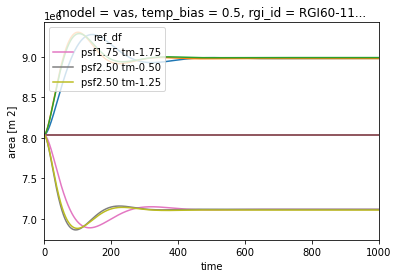

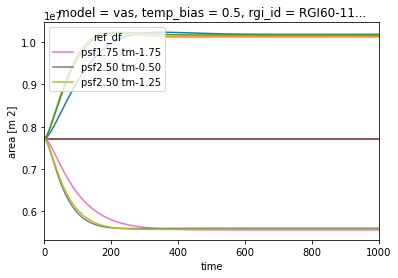

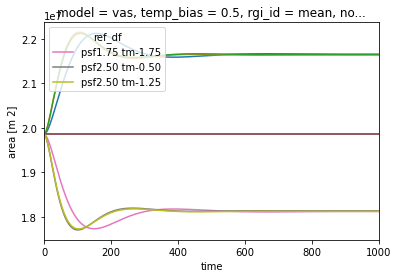

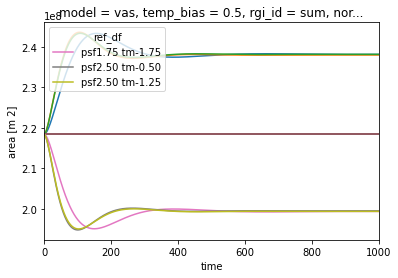

In [19]:
var = 'area'

for rgi_id in ds.rgi_id:
    plt.figure()
    for temp_bias in ds.temp_bias.values:
        ds_sel = ds.sel(rgi_id=rgi_id, temp_bias=temp_bias, normalized=False, mb_model='constant')
        ds_sel[var].plot.line(x='time')
        plt.xlim([0,1e3])

**Final volume of constant mass balance scenario**

In [79]:
# get table with final values of volume for constant mb model
var = 'volume'
mb_m = 'constant'
data = list()

for m in ds.model.values:
    for b in ds.temp_bias.values:
        # select last volume entry from dataset by model and temperature bias
        ds_abs = ds.sel(mb_model=mb_m, model=m, normalized=False, temp_bias=b, rgi_id='sum').isel(time=1000)['volume']
        ds_norm = ds.sel(mb_model=mb_m, model=m, normalized=True, temp_bias=b, rgi_id='sum').isel(time=1000)['volume']
        data.append([np.round(ds_abs.values/1e9), ds_norm.values-1])
        
table = pd.DataFrame(data,
                     index=pd.MultiIndex.from_tuples(list(zip(np.repeat(['vas', 'flowline'], 3),
                                                              np.tile([-.5, 0, .5], 2)))),
                     columns=pd.MultiIndex.from_tuples(list(zip(np.repeat(['volume'], 2),
                                                                np.tile(['abs', 'norm'], 1)))),)
table

volume          
                 abs      norm
vas      -0.5  157.0  0.202402
          0.0  130.0  0.000005
          0.5  108.0 -0.169305
flowline -0.5  258.0  0.585491
          0.0  171.0  0.049369
          0.5   94.0 -0.422163

volume          
                 abs      norm
vas      -0.5  157.0  0.202402
          0.0  130.0  0.000005
          0.5  108.0 -0.169305
flowline -0.5  258.0  0.585491
          0.0  171.0  0.049369
          0.5   94.0 -0.422163

**Difference between constant and random mass balance models in the last 200 years**

In [5]:
# get table with min/mean/max differences in volume between mb models
var = 'volume'
data = list()
for m in ds.model.values:
    for b in ds.temp_bias.values:
        # select volume from dataset by model and temperature bias
        ds_abs = ds.sel(model=m, normalized=False, temp_bias=b, rgi_id='sum').isel(time=slice(800,1000))['volume']
        ds_norm = ds.sel(model=m, normalized=True, temp_bias=b, rgi_id='sum').isel(time=slice(800,1000))['volume']
        # compute absolute differences between the mass balance models
        diff_abs = abs(ds_abs.diff(dim='mb_model').values)
        diff_norm = abs(ds_norm.diff(dim='mb_model').values)
        data.append([diff_abs.min(), diff_norm.min(),
                     diff_abs.mean(), diff_norm.mean(),
                     diff_abs.max(), diff_norm.max()])
        

table = pd.DataFrame(data,
                     index=pd.MultiIndex.from_tuples(list(zip(np.repeat(['vas', 'flowline'], 3),
                                                              np.tile([-.5, 0, .5], 2)))),
                     columns=pd.MultiIndex.from_tuples(list(zip(np.repeat(['min', 'mean', 'max'], 2),
                                                                np.tile(['abs', 'norm'], 3)))),)
table

min                    mean                     max  \
                        abs      norm           abs      norm           abs   
vas      -0.5  1.525707e+06  0.000013  1.050323e+09  0.008050  2.195203e+09   
          0.0  1.414998e+07  0.000109  9.392785e+08  0.007199  1.929534e+09   
          0.5  1.022319e+06  0.000007  8.529590e+08  0.006537  1.742796e+09   
flowline -0.5  1.355808e+09  0.007948  2.456401e+09  0.014704  3.897996e+09   
          0.0  3.302470e+09  0.020263  4.348185e+09  0.026680  5.564029e+09   
          0.5  4.053857e+07  0.000248  1.289899e+09  0.007898  2.575435e+09   

                         
                   norm  
vas      -0.5  0.016824  
          0.0  0.014788  
          0.5  0.013356  
flowline -0.5  0.023554  
          0.0  0.034140  
          0.5  0.015769

In [73]:
# get table with min/mean/max differences in volume between mb models
var = 'volume'
data = list()
for m in ds.model.values:
    for b in ds.temp_bias.values:
        # select volume from dataset by model and temperature bias
        ds_abs = ds.sel(model=m, normalized=False, temp_bias=b, rgi_id='sum').isel(time=slice(800,1000))['volume']
        ds_norm = ds.sel(model=m, normalized=True, temp_bias=b, rgi_id='sum').isel(time=slice(800,1000))['volume']
        # compute absolute differences between the mass balance models
        diff_abs = abs(ds_abs.diff(dim='mb_model').values)
        mean_abs = abs(ds_abs.mean(dim='mb_model').values)
        rel_diff = diff_abs/mean_abs
        data.append([rel_diff.min(), rel_diff.min(),
                     rel_diff.mean()])

In [77]:
table = pd.DataFrame(np.array(data)*100,
                     index=pd.MultiIndex.from_tuples(list(zip(np.repeat(['vas', 'flowline'], 3),
                                                              np.tile([-.5, 0, .5], 2)))),
                     columns=['min', 'mean', 'max'])
table

min      mean       max
vas      -0.5  0.000972  0.000972  0.666440
          0.0  0.010843  0.010843  0.716311
          0.5  0.000943  0.000943  0.782658
flowline -0.5  0.526336  0.526336  0.957068
          0.0  1.951052  1.951052  2.582529
          0.5  0.042963  0.042963  1.377669

**Response times $\tau$**

In [87]:
variables = ['volume', 'area', 'length',]
temp_biases = [-0.5, +0.5]
data = list()
for var in variables:
    data_ = list()
    for m in ds.model.values:
        data__ = list()
        for b in temp_biases:
            ds_sel = ds.sel(mb_model='constant', model=m, temp_bias=b, rgi_id='sum')
            vol = ds_sel.sel(normalized=1)[var]
            vol_eq = vol.isel(time=slice(800,1000)).mean()
            vol_eq_dif = np.abs(vol_eq - vol.isel(time=0))
            vol_dif = np.abs(vol_eq - vol)
            data__.append(int(vol.where(vol_dif < vol_eq_dif*np.exp(-1), drop=True).isel(time=0)['time'].values))
        data_.extend(data__)
    data.append(data_)
    
tau = pd.DataFrame(data, columns=pd.MultiIndex.from_tuples(list(zip(np.repeat(ds.model.values, 2),
                                                                    np.tile(temp_biases, 2)))),
                   index=variables)
tau

vas        fl     
       -0.5  0.5 -0.5  0.5
volume   36   32  116   81
area     49   42  143  110
length   54   48  139   97

**Look at volume increase for equilibrium climate**

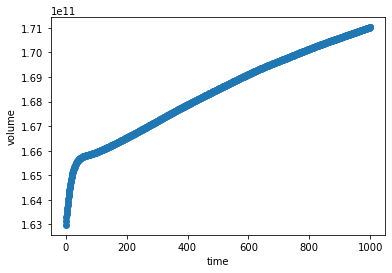

In [53]:
ds_sel = ds.sel(mb_model='constant', model='fl', normalized=False, temp_bias=0, rgi_id='sum')
volume_sel = ds_sel.volume
xr.plot.scatter(ds_sel, 'time', 'volume')

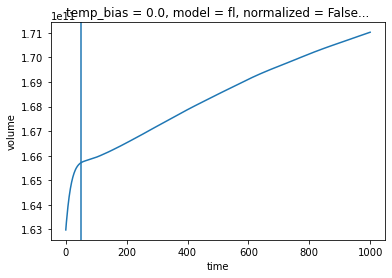

In [54]:
volume_sel.plot()
plt.axvline(50)

In [67]:
np.diff(volume_sel.sel(time=[50, 1000]))/9.5/1e9

array([0.55891099])

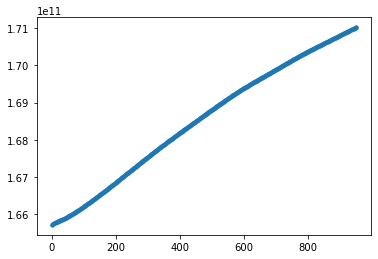

In [56]:
y = volume_sel.sel(time=slice(50, None)).values
plt.plot(y, ls='None', marker='.')

In [58]:
from sklearn.linear_model import LinearRegression
x = np.arange(y.size)
mod = LinearRegression().fit(x.reshape((-1,1)), y)
mod.coef_[0]*100/1e9

0.5826180699742219

### Quantitative analysis for Hintereisferner

In [58]:
# read dataset
path = '/Users/oberrauch/work/master/data/cluster_output/single_glaciers/eq_runs.nc'
ds = read_dataset(path)
# select Hintereisferner
ds = ds.sel(rgi_id='RGI60-11.00897')

**Correlation between vas model and flowline model under random climate**

In [12]:
# get 
variables = ['volume', 'area', 'length',]
mb_m = 'random'
n = True
data = list()
for var in variables:
    data_ = list()
    for b in ds.temp_bias.values:
        # select volume from dataset by temperature bias and geometric variable
        time_slice = slice(400,1000)
        ds_sel = ds.sel(mb_model=mb_m, normalized=n, temp_bias=b).isel(time=time_slice)[var]
        # compute correlation and add to container
        data_.append(float(xr.corr(ds_sel.sel(model='vas'), ds_sel.sel(model='fl'), dim='time').values))
    data.append(data_)
    
pd.DataFrame(data, index=variables, columns=ds.temp_bias.values)

,-0.5,0.0,0.5
volume,0.543715,0.480318,0.686061
area,0.446144,0.442320,0.519969
length,0.653782,0.626061,0.719843


**Response times $\tau$**

In [55]:
variables = ['volume', 'area', 'length',]
temp_biases = [-0.5, +0.5]
data = list()
for var in variables:
    data_ = list()
    for m in ds.model.values:
        data__ = list()
        for b in temp_biases:
            ds_sel = ds.sel(mb_model='constant', model=m, temp_bias=b)
            vol = ds_sel.sel(normalized=1)[var]
            vol_eq = vol.isel(time=slice(800,1000)).mean()
            vol_eq_dif = np.abs(vol_eq - vol.isel(time=0))
            vol_dif = np.abs(vol_eq - vol)
            data__.append(int(vol.where(vol_dif < vol_eq_dif*np.exp(-1), drop=True).isel(time=0)['time'].values))
        data_.extend(data__)
    data.append(data_)
    
tau = pd.DataFrame(data, columns=pd.MultiIndex.from_tuples(list(zip(np.repeat(ds.model.values, 2),
                                                                    np.tile(temp_biases, 2)))),
                   index=variables)
tau

vas        fl     
       -0.5  0.5 -0.5  0.5
volume   39   36   82   74
area     57   52  102  107
length   85   80  122  126

In [60]:
variables = ['volume', 'area', 'length',]
temp_biases = [-0.5, +0.5]
data = list()
for var in variables:
    data_ = list()
    for m in ds.model.values:
        data__ = list()
        for b in temp_biases:
            ds_sel = ds.sel(mb_model='constant', model=m, temp_bias=b)
            vol = ds_sel.sel(normalized=1)[var]
            vol_eq = vol.isel(time=slice(800,1000)).mean()
            vol_eq_dif = np.abs(vol_eq - vol.isel(time=0))
            vol_dif = np.abs(vol_eq - vol)
            data__.append(int(vol.where(vol_dif < vol_eq_dif*np.exp(-1), drop=True).isel(time=0)['time'].values))
        data_.extend(data__)
    data.append(data_)
    
tau = pd.DataFrame(data, columns=pd.MultiIndex.from_tuples(list(zip(np.repeat(ds.model.values, 2),
                                                                    np.tile(temp_biases, 2)))),
                   index=variables)
tau

vas        fl     
       -0.5  0.5 -0.5  0.5
volume   39   36  139   79
area     57   52  159  107
length   85   80  174  123

In [23]:
def rel_dif(a,b):
    return abs(a-b)/((a+b)/2)

In [42]:
i = 4.89
p = 5.26
n = 4.52
rel_dif(abs(i-n),abs(i-p))

0.0

In [30]:
for var, row in tau.iterrows():
    rd = rel_dif(row['vas'][-0.5], row['vas'][+0.5])
    print('VAS {}: {:.2f}'.format(var, rd))
    rd = rel_dif(row['fl'][-0.5], row['fl'][+0.5])
    print('VAS {}: {:.2f}'.format(var, rd))

VAS volume: 0.08
VAS volume: 0.55
VAS area: 0.09
VAS area: 0.39
VAS length: 0.06
VAS length: 0.34


In [ ]:
rel_diff()

**Equilibrium values**

In [453]:
var = ''
data = list()
variables = ['length', 'area', 'volume']
temp_biases = [-0.5, +0.5]
for var in variables:
    data_ = list()
    for m in ds.model.values:
        data__ = list()
        for b in temp_biases:
            ds_sel = ds.sel(mb_model='constant', model=m, temp_bias=b)
            avg_abs = ds_sel.sel(normalized=False, time=1000)[var].mean().values
            avg_norm = ds_sel.sel(normalized=True, time=1000)[var].mean().values
            data__.extend([avg_abs, avg_norm])
        data_.extend(data__)
    data.append(data_)
    
columns = pd.MultiIndex.from_tuples(list(zip(np.repeat(ds.model.values, 4),
                                             np.tile(np.repeat(temp_biases, 2), 2),
                                             np.tile(['abs', 'norm'], 4))))

pd.DataFrame(data, index=variables, columns=columns)

vas                                          \
                     -0.5                                     0.5   
                      abs                norm                 abs   
length  5260.010484931981  1.0746477332822328   4522.030788275755   
area    9017060.380874189  1.1220831733292917   7079797.811779213   
volume  698626814.5539591  1.1716070660297502  500971514.63398063   

                                            fl                      \
                                          -0.5                       
                      norm                 abs                norm   
length   0.923874610207331              9900.0   1.434782608695652   
area    0.8810101806594342  10677439.074325213  1.3287007310011463   
volume  0.8401363277181585  1369683280.7388396  1.7113252731353152   

                                               
                      0.5                      
                      abs                norm  
length             4200.0  0.6086956521739131  
area    6170756.249375396  0.7678890305345192  
volume  465435483.0103007   0.581529698354654

In [491]:
var = ''
data = list()
variables = ['volume', 'area', 'length',]
models = ['vas', 'fl']
temp_biases = [+0.5, -0.5]
for var in variables:
    data_ = list()
    for m in models:
        data__ = list()
        for b in temp_biases:
            ds_sel = ds.sel(mb_model='constant', model=m, temp_bias=b)
            avg_abs = ds_sel.sel(normalized=False, time=999)[var].values
            avg_norm = ds_sel.sel(normalized=True, time=999)[var].values
            data__.append('{:.2e} ({:.0f}%)'.format(avg_abs, avg_norm*1e2))
        data_.extend(data__)
    data.append(data_)
    
columns = pd.MultiIndex.from_tuples(list(zip(np.tile(temp_biases, 2),
                                             np.repeat(models, 2))))

eq_values = pd.DataFrame(data, index=variables, columns=columns).T.sort_index(level=0, sort_remaining=False, ascending=True)
eq_values.T

-0.5                              0.5                
                    vas               fl             vas              fl
volume  6.99e+08 (117%)  1.37e+09 (171%)  5.01e+08 (84%)  4.65e+08 (58%)
area    9.02e+06 (112%)  1.07e+07 (133%)  7.08e+06 (88%)  6.17e+06 (77%)
length  5.26e+03 (107%)  1.00e+04 (145%)  4.52e+03 (92%)  4.20e+03 (61%)

In [492]:
print(eq_values.T.to_latex())

\begin{tabular}{lllll}
\toprule
{} & \multicolumn{2}{l}{-0.5} & \multicolumn{2}{l}{0.5} \\
{} &              vas &               fl &             vas &              fl \\
\midrule
volume &  6.99e+08 (117\%) &  1.37e+09 (171\%) &  5.01e+08 (84\%) &  4.65e+08 (58\%) \\
area   &  9.02e+06 (112\%) &  1.07e+07 (133\%) &  7.08e+06 (88\%) &  6.17e+06 (77\%) \\
length &  5.26e+03 (107\%) &  1.00e+04 (145\%) &  4.52e+03 (92\%) &  4.20e+03 (61\%) \\
\bottomrule
\end{tabular}



**Initial values**


([<matplotlib.axis.XTick at 0x145024d30>,
 [Text(0.5, 0, 'vas'), Text(3.5, 0, 'flowline')])

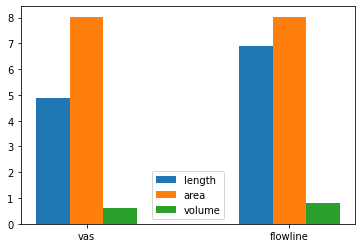

In [525]:
for i, var in enumerate(variables[::-1]):
    ds_plot = ds.sel(normalized=False, time=0, mb_model='constant', temp_bias=0)
    x = np.array([0,3])
    plt.bar(x+(i*0.5), ds_plot[var]/10**(3*(i+1)), label='{}'.format(var), width=0.5)

plt.legend()
plt.xticks([0.5, 3.5], ['vas', 'flowline'])

In [528]:
ds_plot

<xarray.DataArray 'length' (model: 2)>
array([4894.63693267, 6900.        ])
Coordinates:
    calendar_month  int64 10
    calendar_year   int64 -1
    hydro_year      int64 0
    hydro_month     int64 1
  * model           (model) object 'vas' 'fl'
    normalized      bool False
    temp_bias       float64 0.0
    time            float64 0.0
    rgi_id          <U14 'RGI60-11.00897'
    mb_model        <U8 'constant'
Attributes:
    description:  Glacier length
    units:        m

In [ ]:
    x = np.array([0,2,4])
    plt.bar(x+(i*0.5), ds_plot/10**(3*(i+1)), label='{}'.format(var), width=0.5)



800364081.71
8036000.00
6900.00
596297884.17
8036000.00
4894.64


(0.0, 10.0)

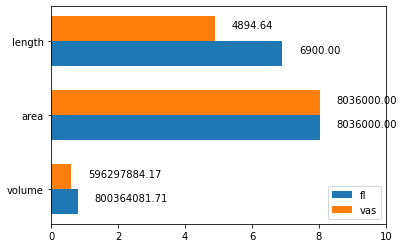

In [613]:
model = 'vas', 'flowline'
for i, model in enumerate(models[::-1]):
    ds_plot = ds.sel(normalized=False, time=0, mb_model='constant', temp_bias=0, model=model)
    x = np.array([0,1.5,3])+0.25+i*0.5
    values = ds_plot.volume, ds_plot.area, ds_plot.length
    height = ds_plot.volume/1e9, ds_plot.area/1e6, ds_plot.length/1e3
    plt.barh(x, height, label=model, height=0.5)

    for x_, y, v in zip(x, height, values):
        plt.text(y + 0.5, x_, '{:.2f}'.format(v.values), rotation=0)
        print('{:.2f}'.format(v.values))
    
plt.legend(loc=4)
plt.yticks([0.5, 2, 3.5], variables)
plt.xlim([0, 10])

In [615]:
596297884.17/(4894.64**2*1.4179698506016887)

17.553137769257216

In [609]:
ds_corr = ds.sel(model='vas', mb_model='random', normalized=False, time=slice(0,100)).volume
xr.corr(ds_corr.sel(temp_bias=+.5), ds_corr.sel(temp_bias=-.5))

<xarray.DataArray 'volume' ()>
array(-0.69395365)
Coordinates:
    model       <U3 'vas'
    normalized  bool False
    rgi_id      <U14 'RGI60-11.00897'
    mb_model    <U6 'random'

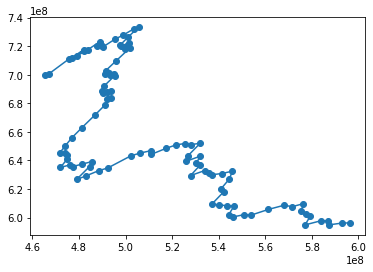

In [610]:
plt.plot(ds_corr.sel(temp_bias=+.5), ds_corr.sel(temp_bias=-.5), marker='o')

In [588]:
1.4179698506016887 * 8

count    1000.000000
mean       24.700000
std        87.450315
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       900.000000
Name: length, dtype: float64